# A manually worked GP

Follows roughly https://www.robots.ox.ac.uk/~mebden/reports/GPtutorial.pdf

See also [RW](http://www.gaussianprocess.org/gpml/chapters/)

## Imports etc

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

import gp_helpers.manual_gp as h

In [2]:
%run ~/.jupyter/config.ipy

# What's the problem GP solves?

We have some data with some uncertainty and we want to predict some other data.

[(-1.2, 0.2)]

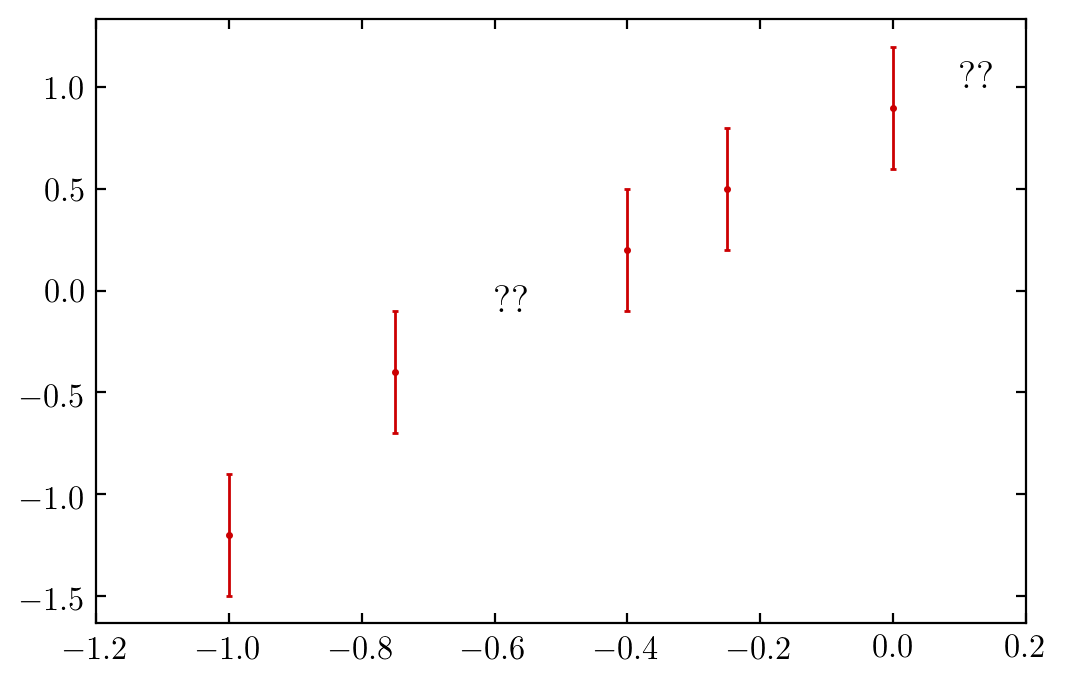

In [8]:
train_x = np.array([-1, -0.75, -0.4, -0.25, 0])
train_y = np.array([-1.2, -0.4, 0.2, 0.5, 0.9])
std_y = 0.3

_, ax = plt.subplots()
ax.errorbar(train_x, train_y, yerr=std_y, linestyle="", marker=".")

ax.annotate("??", xy=(0.1, 1.0))
ax.annotate("??", xy=(-0.6, -0.1))

ax.set(xlim=(-1.2, 0.2))

# Basic Theory

## Covariance Function and Matrix

We can define a covariance function that describes how similar data at different locations should be. 
This function can be of basically any form, as long as it takes two vectors specifying two locations and returns a scalar covariance.

$$
k(\vec{x_1}, \vec{x_2}) = k(\vec{x_2}, \vec{x_1}) = c
$$

Many commonly used covariance functions (e.g. the squared exponential (SE), a specific type of [RBF](https://en.wikipedia.org/wiki/Radial_basis_function) or radial basis function) just use the euclidian distance (possibly weighted) between the points.
In SE the covariance decreases with increasing distance. The intuition behind this is that two points that are close together should be similar (have a large covariance) whereas two points far apart should be independent.

$$
k_{\textrm{SE}}(x_1, x_2) = \sigma^2\exp\left(-\frac{(x_1 - x_2)^2}{2\ell^2}\right)
$$

$k_{\textrm{SE}}$ has two hyperparameters: 
* $\sigma^2$ or the output variance, determines the average distance away from the mean.
* $\ell$ or the lengthscale, determines the rate at which the function varies. Large values mean a smooth GP, small values a spiky one.

See [this notebook](./Hyperparam_exploration.ipynb) to see the effects of these parameters. See [the kernel cookbook](https://www.cs.toronto.edu/~duvenaud/cookbook/) for examples of many more covariance matrixes.

Once the covariance function and hyperparameters have been defined, use them to construct a covariance matrix where $C_{i,j} = k(\vec{x_i}, \vec{x_j})$ for every location that you care about.

In [61]:
variance = 2
length_scale = 0.2

def compute_cov_matrix(x, variance, length_scale, train_err):
    xCol = np.expand_dims(x, 1)
    xRow = np.expand_dims(x, 0)
    # Squared exponential
    basic_cov = variance * np.exp(-(xRow - xCol)**2/(2*length_scale))
    # Account for uncertainty on the data
    data_err_cov = np.identity(len(x)) * train_err**2
    return (basic_cov + data_err_cov)


## Predict a single point

What is every location that you care about? Presumably you need to care about the locations at which you have data (the training set). However, you also care about the locations at which you want to predict data (the test set). Let's construct a covariance matrix for some training data and now a test set that consists of a single point.

A major assumption that I am not 100% ok with, is that we can view our data as draws from a multivariate Gaussian. I just don't know what this means... But, given this, we now have:

$$
\begin{bmatrix}
    {\bf y} \\
    {y_\ast}
\end{bmatrix} \sim 
N\Big(0, \begin{bmatrix}
    {K, K_\ast^{T}} \\
    {K_\ast, K_{\ast\ast}}
\end{bmatrix}\Big)
$$

where ${\bf y}$ is the training data, $y_\ast$ is the test point, $K$ the covariance matrix of the training data, $K_\ast$ the covariance between the training and test point.

However, ${\bf y}$ is known! So we are interested in the conditional probability $P(y_\ast | {\bf y})$. Some matrix algebra that I don't understand tells us that $y_\ast \sim N(K_\ast K^{-1} {\bf y}, K_{\ast \ast} - K_\ast K^{-1} K_\ast^T)$.

So we are done! We have a predition with a mean (and importantly a variance) for our test point. Some notes:
* We need to invert the covariance matrix of the training set. Matrix inversion is (to first order) $O(n^{3})$. You can't have too many training points!
* This matrix algebra scales to predicting more than one point! Just imagine $K_\ast$ as an $(n, m)$ matrix where $n$ is the number of test points and $m$ the number of training points.

This looks reasonable...


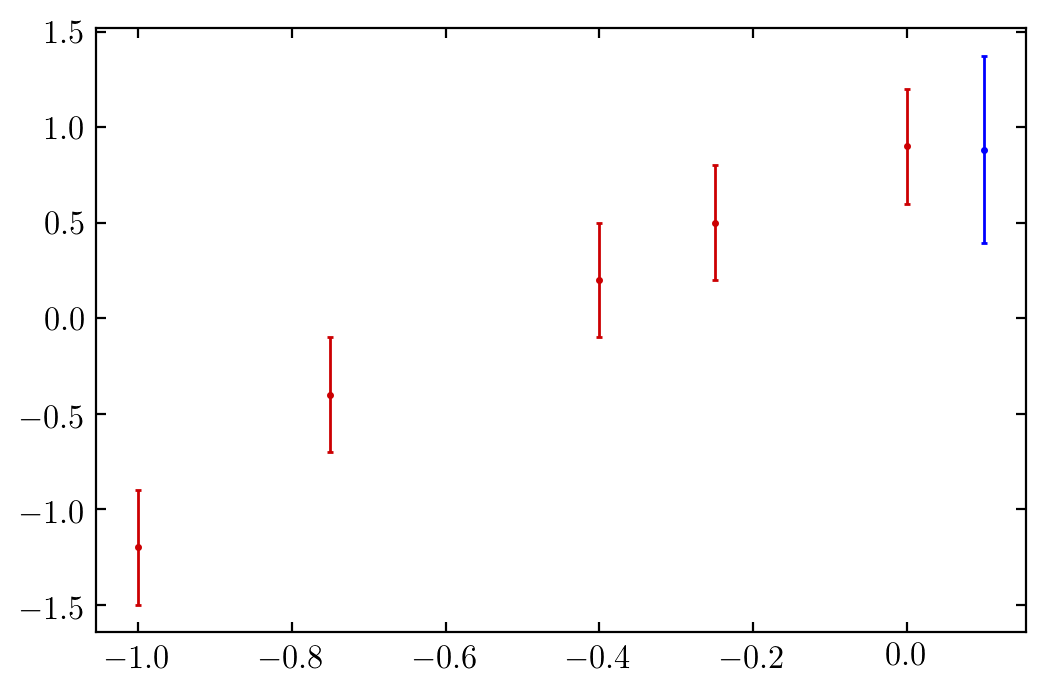

In [62]:
# we defined the training data way up top. Now the test data
test_x = np.array([0.1])

# Construct the cov matrix - we assume the mean is 0. With this we can sample from the mv gaussian.
cov_matrix = compute_cov_matrix(np.concatenate((train_x, test_x)), variance, length_scale, std_y)

# Slice the cov matrix into various components - this is K, K*, K**
n = -1
cov_train_with_train = cov_matrix[:n, :n]
cov_test_with_train = cov_matrix[n:, :n]
cov_test_with_test = cov_matrix[n:, n:]

# This is the linear alg that I don't fully understand (yet!) to get the value of the test point
pred_y = np.matmul(cov_test_with_train, np.matmul(np.linalg.inv(cov_train_with_train), train_y))
var_y = np.diag(
    cov_test_with_test - np.matmul(
        cov_test_with_train, np.matmul(
            np.linalg.inv(cov_train_with_train), cov_test_with_train.T)
    )
)

_, ax = plt.subplots()
ax.errorbar(train_x, train_y, yerr=std_y, linestyle="", marker=".")
ax.errorbar(test_x, pred_y, yerr=np.sqrt(var_y), marker=".")
print("This looks reasonable...")

## Describe a function

While we used our GP to predict the value at a single point, it can predict at any point. This is just a function! Let's use it to plot the values over the full domain of $\vec{x}$ that we are interested in.

In [63]:
test_x2 = np.linspace(-1.5, 0.3, num=500)

# This is just the same code as for the single point factored out into a function
pred_ys, var_ys = h.build_gp_model(train_x, train_y, test_x2, length_scale, variance, std_y)

Looks pretty good. Though if I were to make a complaint the uncertainty looks too big at the ends


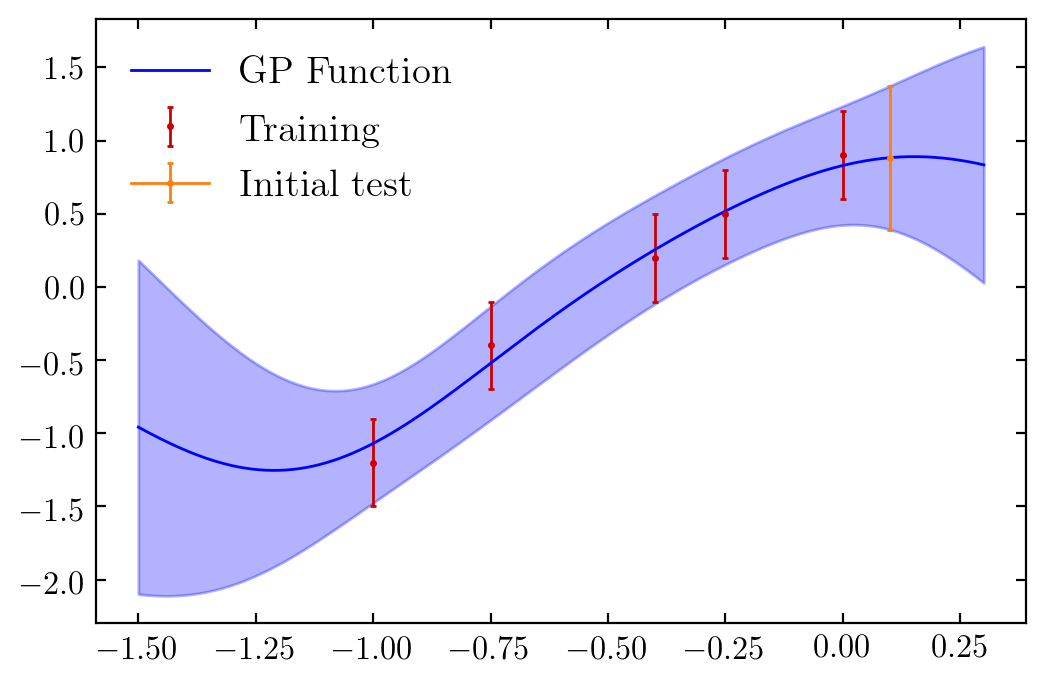

In [72]:
_, ax = plt.subplots()
ax.errorbar(train_x, train_y, yerr=std_y, linestyle="", marker=".", label="Training")

l = ax.plot(test_x2, pred_ys, label="GP Function")
ax.fill_between(test_x2, pred_ys - np.sqrt(var_ys), pred_ys + np.sqrt(var_ys), alpha=0.3, color=l[0].get_color())
ax.errorbar(test_x, [pred_y], yerr=[np.sqrt(var_y)], marker=".", label="Initial test")
ax.legend()
print("Looks pretty good. Though if I were to make a complaint the uncertainty looks too big at the ends")

## Hyperparameters

What went into making this function? Each point depends on:
* The training data
* The covariance matrix which depends on:
    * The choice of covariance function
    * The hyperparameters $\theta$ to that function (in this case $\sigma$ and $\ell$)


While I don't think there is any argument that the training data should inform the predictions for the test set, how did we chose the form of the covariance function and hyperparameters? Pretty arbitrarily... Let's ignore the covariance function for now and just focus on the hyperparameters.

In practice, I played with the hyperparameters to get something that looked "reasonable", though as I mentioned above, the uncertainties do look too large. What properties should a function with well chosen hyperparameters fulfill? It should be informed by the data we do have - the function we end up with should be able, with high probability, to generate the training data (bayesian likelihood). It should also be informed by whatever prior information we have (baysian prior). If we don't have much of a prior, this is just (see [here](./multivariate_gaussian.ipynb)):

$$
\log\,P(\vec{y} | \vec{\mu}, \Sigma) = \frac{1}{2} \left(-  k \log (2 \pi) - \log (| \Sigma |) - \vec{y}^T \Sigma^{-1} \vec{y} \right)
$$

So we have have our data inform our hyperparameters by optimizing that function, using your favourite optimization algo.

Now using (1.1411663312418743, 0.5303697888097618) rather than (2, 0.2) as variance and length scale
Nice...


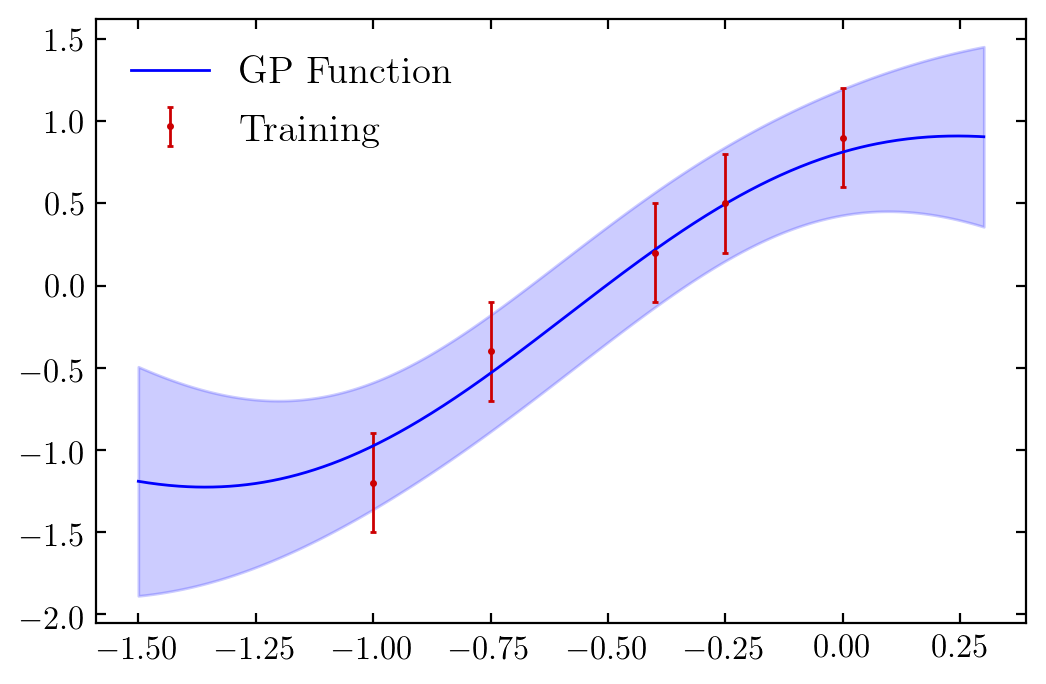

In [70]:
# We want to find a high log prob so we minimize the negative log prob
def neg_log_prob(theta):
    cov_matrix = compute_cov_matrix(train_x, theta[0], theta[1], std_y)
    return -scipy.stats.multivariate_normal(cov=cov_matrix).logpdf(train_y)

res = scipy.optimize.minimize(
    neg_log_prob, 
    np.array([variance, length_scale]),
)

variance2, length_scale2 = res.x
print("Now using ({}, {}) rather than ({}, {}) as variance and length scale".format(
      variance2, length_scale2, variance, length_scale))
pred_ys2, var_ys2 = h.build_gp_model(train_x, train_y, test_x2, length_scale2, variance2, std_y)
h.plot(train_x, train_y, std_y, test_x2, pred_ys2, var_ys2)

print("Nice...")

# Function spaces + some formalism

Any discussion about GP at some point talks about function spaces, e.g. from RW

*One can think of a Gaussian process as defining a distribution over functions, and inference taking place directly in the space of functions.* 

What is a function space?

In [73]:
# Lets assume we just have a set of x variables
x = np.linspace(0, 3, 80)

# We also have a covariance function, mean function and hyperparameters.
max_covariance = 10
length_scale = 0.5

def fs_covariance_function(x):
    xCol = np.expand_dims(x, 1)
    xRow = np.expand_dims(x, 0)
    basic_cov = max_covariance * np.exp(-(xRow - xCol)**2/(2*length_scale))
    return basic_cov

def fs_mean_function(x):
    return np.zeros_like(x)

# We can now generate a covariance matrix and mean vector
cov_matrix = fs_covariance_function(x)
mean_vector = fs_mean_function(x)

We now have everything we need to generate a GP over these input points. By which we mean of course, we can assign our $y$ as a draw from from,

$$
\vec{y} = N(\vec{\mu}, \Sigma)
$$

which can be thought of as generating a candidate mapping from $x \rightarrow y$. Or in other words, we are defining a candidate function $y = f(x)$!

Let's look at a couple of candidate functions.

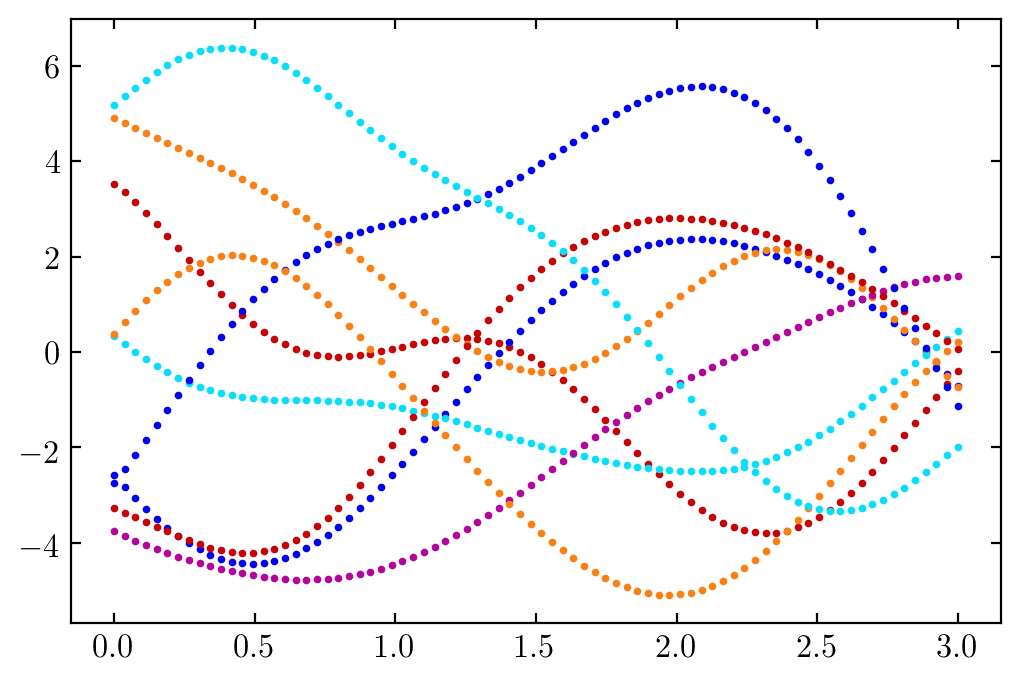

In [75]:
_, ax = plt.subplots()
for i in range(9):
    y_pred = np.random.multivariate_normal(mean_vector, cov_matrix)
    ax.scatter(x, y_pred, s=3)

That's a pretty wide range of functions, all of whom obey the only constraints we have currently put on them - they should be drawn from a given covariance matrix and mean vector.

However when doing regression we also condition our function on some data. This conditioning limits the range of functions available to us. Instead of:

$$
y_i \sim N(0, K)_i
$$

we have
$$
y_i \sim N(K_\ast K^{-1} {\bf y}, K_{\ast \ast} - K_\ast K^{-1} K_\ast^T)_i
$$

Another way of thinking about this is that if we have known data points, only functions that go through those data points are valid.

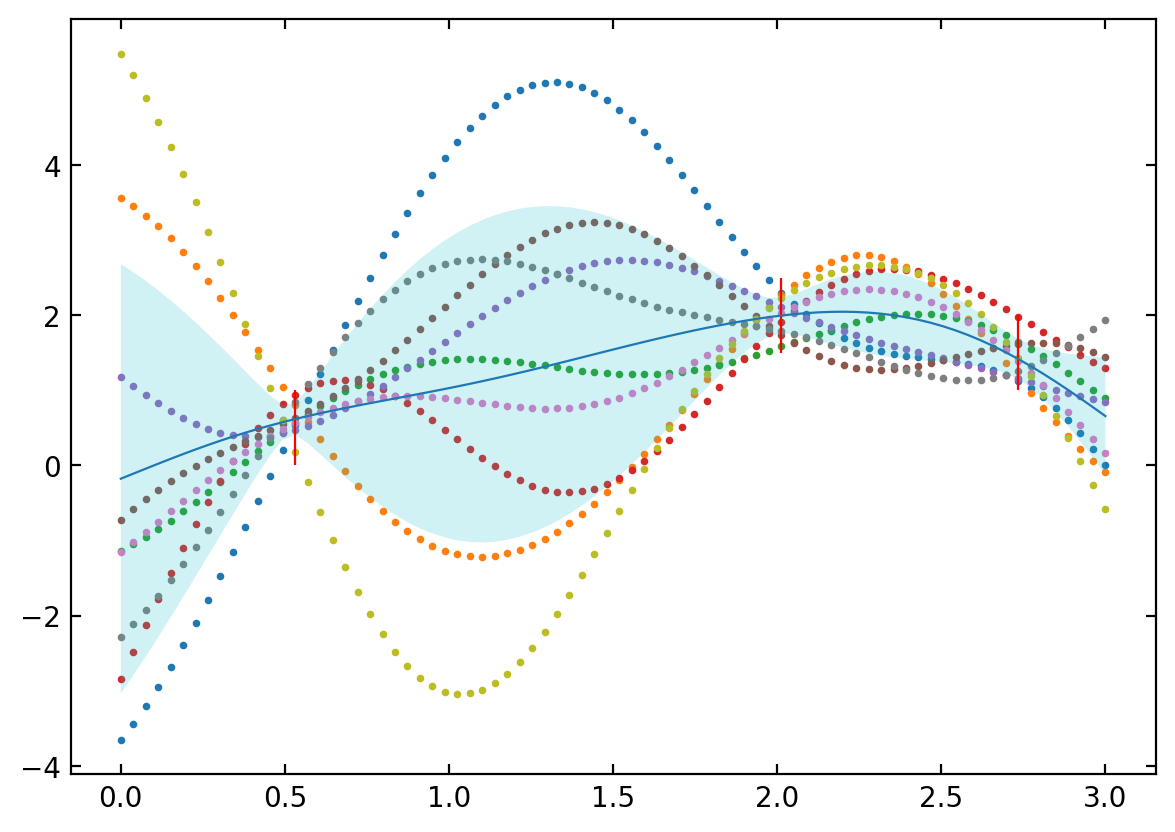

In [49]:
# We can add a couple of observations to constrain the valid functions.
# Let's say that we know that at x = 2 our value is 2 and at x = 4 it is 0, in both cases +/- 0.5
idx_2 = np.searchsorted(x, 2)
idx_4 = np.searchsorted(x, 0.5)
idx_5 = np.searchsorted(x, 2.7)


_, ax = plt.subplots(figsize=(7, 5))
ax.errorbar([x[idx_2], x[idx_4], x[idx_5]], [2, 0.5, 1.5], yerr=0.5, color="red", ls="")
num_runs = 9
mean = np.zeros((num_runs, len(x)))
for i in range(num_runs):
    while True:
        y_pred = np.random.multivariate_normal(mean_vector, cov_matrix)
        # This is a simplification. We should prefer things closer to the center and not have a hard cutoff
        # I'm not sure if p(accept) should be a gaussian, in which case we would be biased 
        # closer to the mean function.
        if 1.5 < y_pred[idx_2] < 2.5 and 0 < y_pred[idx_4] < 1 and 1 < y_pred[idx_5] < 2:
            break
    ax.scatter(x, y_pred, s=3)
    mean[i] = y_pred

    
# We can match out observations by waiting until be have a mv_gaussian that hits them. This tightly
# constrains points near to our observation and weakly constrains points further away.
# You can imagine that with enough "gates" (data points) to go through, all locations are well constrained.
# This is fantastically slow way of sampling from a mv_gauss with constraints. The linear algebra
# I used above and don't understand is just a fast way of sampling y* given y and a covariance matrix.

# But this is all GP is - given some hyperparams (description of how func should vary) and some
# data constraints (description of gates the func should pass through) we can find all possible
# funcs that satisfy these two criteria.
# By finding all possible solutions, we can then get the mean value of those functions at each point
# We can also find the dispersion in the possible functions and that is the variance.
# Note that above we got the variance by using more linear algebra I don't understand yet. In the same way 
# that you can use the covariance matrix to sample y* you can use it to find the dispersion of possible
# vals at that x.

func_mean = np.mean(mean, axis=0)
func_std = np.std(mean, axis=0)
ax.plot(x, func_mean)
ax.fill_between(x, func_mean - func_std, func_mean + func_std, alpha=0.2)

# Kernel functions

In [7]:
# Factor out what we have already seen into conventient GP helpers
import gp_helpers.manual_gp as gp

In [8]:
# So far we have seen kernel functions that specify that points near to each other should be similar.
# We have also seen a piece of a kernel function that does something with data errors. I don't understand this.
# But what about data that has some other pattern? Maybe it is periodic?

f = np.sin
err = 0.2

all_x = np.linspace(0, 30*np.pi, num=200)
#x = np.linspace(0, 30*np.pi, num=100)
x = np.random.random(size=100) * 30 * np.pi
y = f(x) + np.random.normal(0, err, size=len(x))

## Squared Exp

[[1.00000000e+000 9.50305227e-086 6.72972939e-097 ... 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [9.50305227e-086 1.00000000e+000 0.00000000e+000 ... 4.27036739e-267 1.06621341e-281 1.08534524e-296]
 [6.72972939e-097 0.00000000e+000 1.00000000e+000 ... 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 ...
 [0.00000000e+000 4.27036739e-267 0.00000000e+000 ... 1.00000000e+000 6.38516952e-001 1.66222469e-001]
 [0.00000000e+000 1.06621341e-281 0.00000000e+000 ... 6.38516952e-001 1.00000000e+000 6.38516952e-001]
 [0.00000000e+000 1.08534524e-296 0.00000000e+000 ... 1.66222469e-001 6.38516952e-001 1.00000000e+000]]


485521.78117080877

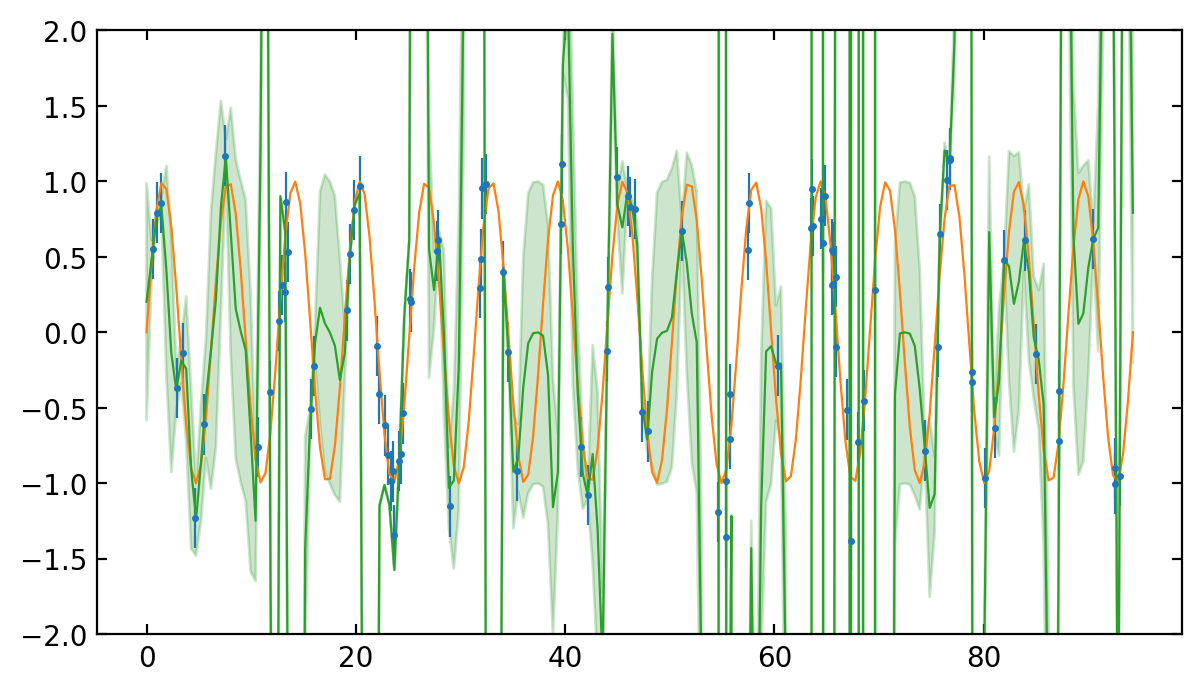

In [23]:
# This hideously underestimates the errors as it needs to hit exactly all of the
def squared_exponential(x, length_scale, max_covariance):
    return max_covariance * np.exp(-(np.expand_dims(x, 0) - np.expand_dims(x, 1))**2/(2*length_scale**2))
    
pred_ys, var_ys = gp.build_gp_model(x, y, all_x, squared_exponential, l_scale=0.5, max_cov=1)
var_ys = np.abs(var_ys)
ax = gp.plot(x, y, err, f, all_x, pred_ys, var_ys)
np.sum((f(all_x) - pred_ys)**2)/len(pred_ys)

## Squared Exp with error term

[[1.04000000e+000 9.50305227e-086 6.72972939e-097 ... 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 [9.50305227e-086 1.04000000e+000 0.00000000e+000 ... 4.27036739e-267 1.06621341e-281 1.08534524e-296]
 [6.72972939e-097 0.00000000e+000 1.04000000e+000 ... 0.00000000e+000 0.00000000e+000 0.00000000e+000]
 ...
 [0.00000000e+000 4.27036739e-267 0.00000000e+000 ... 1.00000000e+000 6.38516952e-001 1.66222469e-001]
 [0.00000000e+000 1.06621341e-281 0.00000000e+000 ... 6.38516952e-001 1.00000000e+000 6.38516952e-001]
 [0.00000000e+000 1.08534524e-296 0.00000000e+000 ... 1.66222469e-001 6.38516952e-001 1.00000000e+000]]


0.19167374046792518

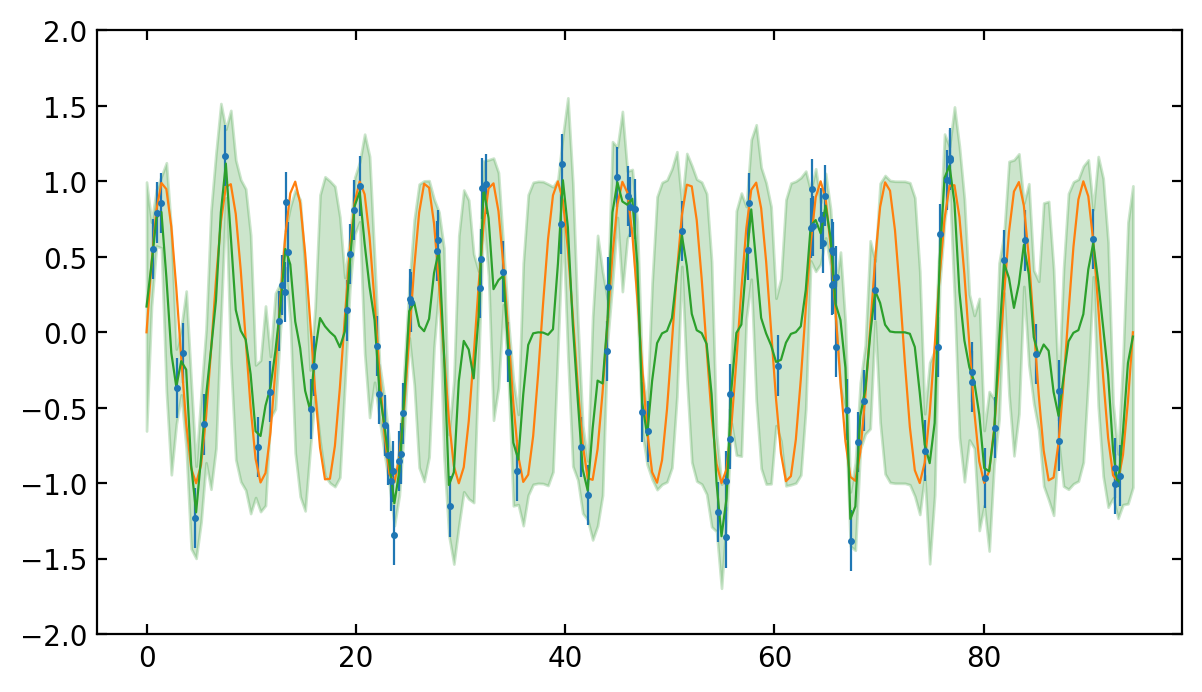

In [17]:
# By doing this, the diagonal has a slightly larger covariance. The off diagonal doesn't change.
# Specifically, it goes from max_covariance -> max_covariance + err**2
def squared_exponential_w_err(x, length_scale, max_covariance, err, train_len):
    se = squared_exponential(x, length_scale, max_covariance)
    data_err = np.zeros((len(x),len(x)))
    for i in range(train_len): data_err[i][i] = err**2 # We don't want to add this to the test data
    return se + data_err

pred_ys, var_ys = gp.build_gp_model(x, y, all_x, squared_exponential_w_err, l_scale=0.5, max_cov=1, err=err, train_len=len(x))
ax = gp.plot(x, y, err, f, all_x, pred_ys, var_ys)
np.sum((f(all_x) - pred_ys)**2)/len(pred_ys)

### Toy showing why we need the error term

[[1.         0.96923323 0.99221794]
 [0.96923323 1.         0.99221794]
 [0.99221794 0.99221794 1.        ]]
[0.15764718] [0.01104798]
[[1.0025     0.96923323 0.99221794]
 [0.96923323 1.0025     0.99221794]
 [0.99221794 0.99221794 1.        ]]
[0.15744729] [0.03728033]
[[1.0025     0.96923323 0.96923323 ... 0.89568863 0.88917245 0.8824969 ]
 [0.96923323 1.0025     0.8824969  ... 0.97622177 0.97283518 0.96923323]
 [0.96923323 0.8824969  1.         ... 0.77200877 0.76346534 0.7548396 ]
 ...
 [0.89568863 0.97622177 0.77200877 ... 1.         0.99988287 0.99953155]
 [0.88917245 0.97283518 0.76346534 ... 0.99988287 1.         0.99988287]
 [0.8824969  0.96923323 0.7548396  ... 0.99953155 0.99988287 1.        ]]


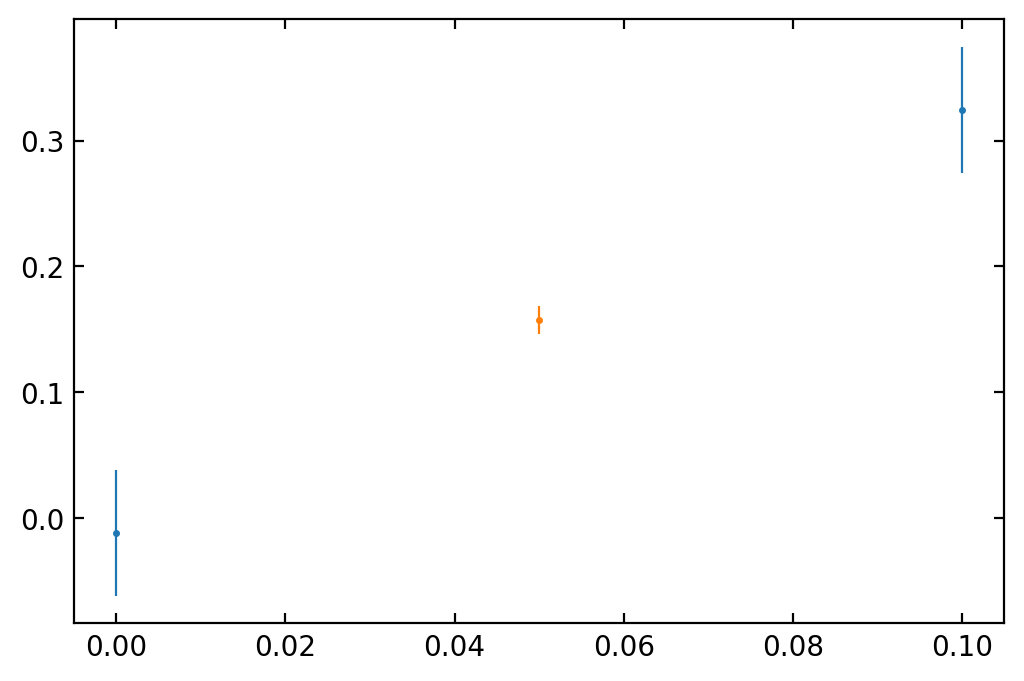

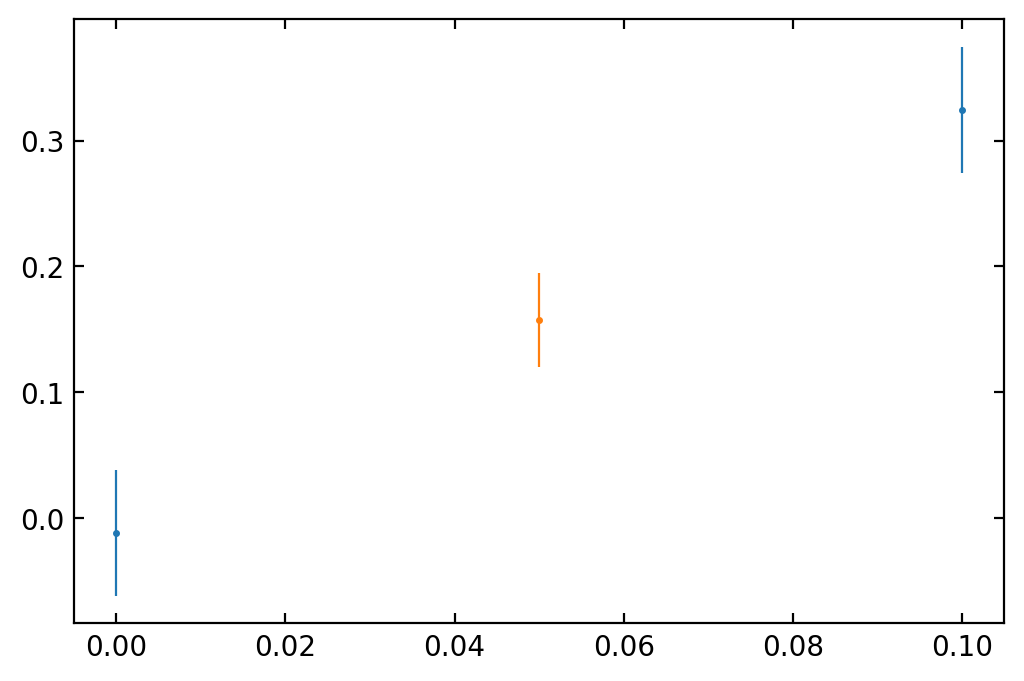

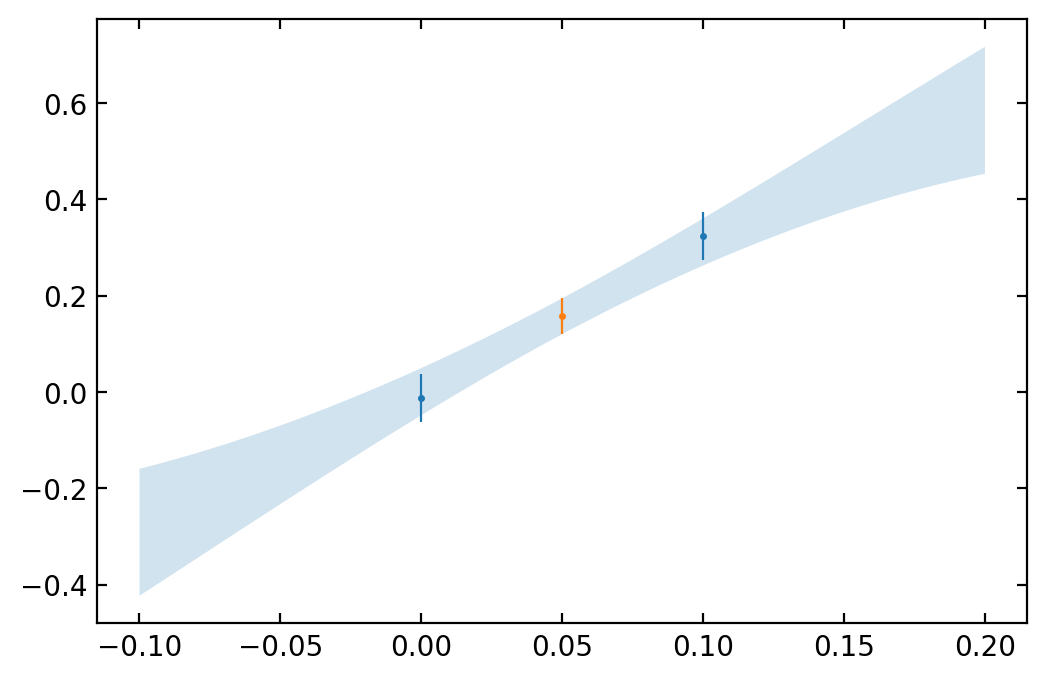

In [361]:
# Toy model to explain why we need the error term
def f(x):
    return 3*x
t_x = np.array([0, 0.1])
t_y = f(t_x)
err = 0.05
t_y += np.random.normal(0, err, size = 2) # with noise


gp_x = np.array([0.05])

for i in range(2):
    if i == 0:
        gp_y, gp_var = gp.build_gp_model(t_x, t_y, gp_x, squared_exponential, l_scale=0.4, max_cov=1)
    else:
        gp_y, gp_var = gp.build_gp_model(t_x, t_y, gp_x, squared_exponential_w_err, l_scale=0.4, max_cov=1, err=err, train_len=len(t_x))

    print(gp_y, np.sqrt(gp_var))
    
    _, ax = plt.subplots()
    ax.errorbar(t_x, t_y, yerr=err, ls="", marker=".")
    ax.errorbar(gp_x, gp_y, yerr=np.sqrt(gp_var), ls="", marker=".")
    
l_x = np.linspace(-0.1, 0.2)

l_y, l_var = gp.build_gp_model(t_x, t_y, l_x, squared_exponential_w_err, l_scale=0.4, max_cov=1, err=err, train_len=len(t_x))
_, ax = plt.subplots()
ax.errorbar(t_x, t_y, yerr=err, ls="", marker=".")
ax.errorbar(gp_x, gp_y, yerr=np.sqrt(gp_var), ls="", marker=".")
ax.fill_between(l_x, l_y - np.sqrt(l_var), l_y + np.sqrt(l_var), alpha=0.2)

## Periodic

[[2.04       0.15076171 0.23324567 ... 0.19284802 0.14617109 0.13575331]
 [0.15076171 2.04       0.36942489 ... 0.46352583 0.70427983 0.92752953]
 [0.23324567 0.36942489 2.04       ... 0.97422662 0.78910595 0.54031745]
 ...
 [0.19284802 0.46352583 0.97422662 ... 2.         1.53428745 0.82586785]
 [0.14617109 0.70427983 0.78910595 ... 1.53428745 2.         1.53428745]
 [0.13575331 0.92752953 0.54031745 ... 0.82586785 1.53428745 2.        ]]


0.03356158967883768

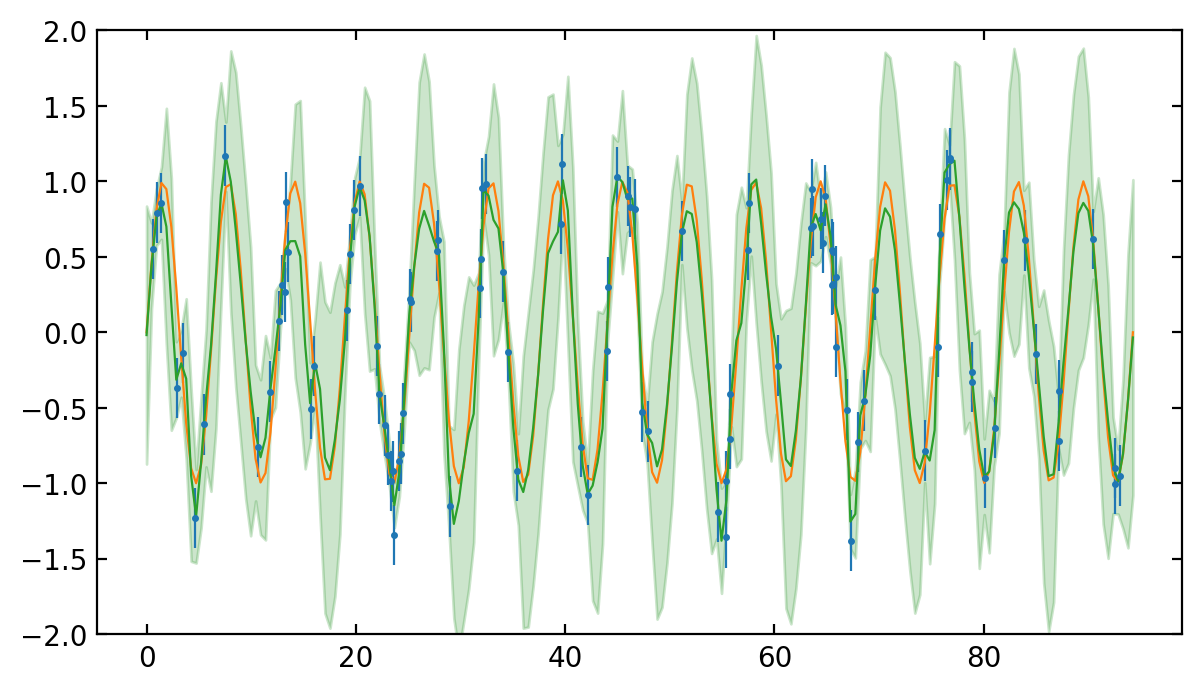

In [32]:
# What if we know what we are trying to fit is periodic, and we know the period? We then want to encode 
# in our kernel that the value of each point should not only depend on points near to it but also to points
# in similar phase

def periodic(x, length_scale, max_covariance, err, train_len, freq):
    se_w_err = squared_exponential_w_err(x, length_scale, max_covariance, err, train_len)
    p = np.exp(-2*np.sin(
        (np.expand_dims(x, 0) - np.expand_dims(x, 1)) * freq # Whole numbers -> in phase. Z + 1/2 -> completely out of phase
        * np.pi # Therefore make sure sin(...) = 0 for whole numbers and = 1 for Z + 1/2
    )**2)
    return se_w_err + p

pred_ys, var_ys = gp.build_gp_model(x, y, all_x, periodic, l_scale=0.5, max_cov=1, err=err, train_len=len(x), freq=1/(2*np.pi))
ax = gp.plot(x, y, err, f, all_x, pred_ys, var_ys)

np.sum((f(all_x) - pred_ys)**2)/len(pred_ys)

# Interesting behaviour

## The model has smaller errors on the data points and often has the smallest error between the data points.

I think this makes sense. If you have two data points very close together you can say that the value of a point in between them should be ~ the mean of the two we know.
The std-dev on the mean `sqrt(2*err^2)/2 = err / sqrt(2)` (remember that in general errors on the mean go as `1/sqrt(n)`.

On the data points, we can use some info from nearby points to reduce error.

[[1.0001     0.99995    0.99995    ... 0.99980122 0.99980062 0.99980002]
 [0.99995    1.0001     0.99980002 ... 0.9999506  0.9999503  0.99995   ]
 [0.99995    0.99980002 1.         ... 0.9995519  0.999551   0.9995501 ]
 ...
 [0.99980122 0.9999506  0.9995519  ... 1.         1.         1.        ]
 [0.99980062 0.9999503  0.999551   ... 1.         1.         1.        ]
 [0.99980002 0.99995    0.9995501  ... 1.         1.         1.        ]]


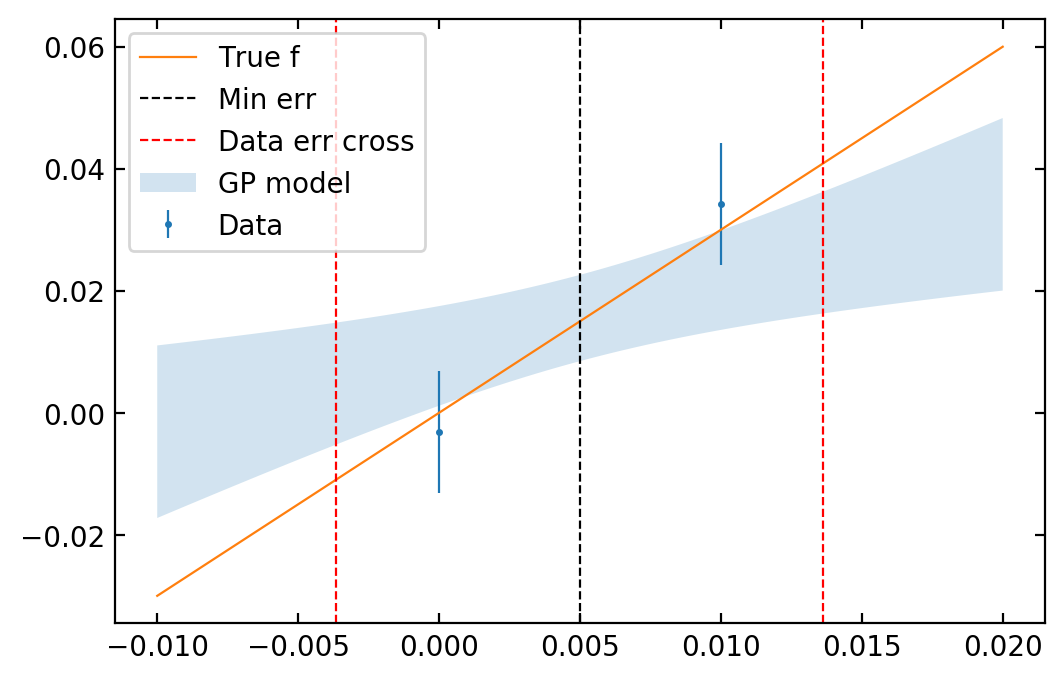

In [100]:
# Linear model + training set
def f(x):
    return 3*x
t_x = np.array([0, 0.01])
t_y = f(t_x)
err = 0.01
t_y += np.random.normal(0, err, size = 2) # with noise

# Test set
l_x = np.linspace(-0.01, 0.02, num=1000)

l_y, l_var = gp.build_gp_model(t_x, t_y, l_x, squared_exponential_w_err, l_scale=1, max_cov=1, err=err, train_len=len(t_x))
_, ax = plt.subplots()
ax.errorbar(t_x, t_y, yerr=err, ls="", marker=".", label="Data")
ax.fill_between(l_x, l_y - np.sqrt(l_var), l_y + np.sqrt(l_var), alpha=0.2, label="GP model")
ax.plot(l_x, f(l_x), label="True f")
assert np.isclose(err/np.sqrt(2), np.min(np.sqrt(l_var)), atol=0.001)

ax.axvline(l_x[np.argmin(np.sqrt(l_var))], ls="--", color="black", label="Min err")

crs = np.nonzero(np.diff(np.sign(np.sqrt(l_var) - err)))[0]
ax.axvline(l_x[crs[0]], ls="--", color="red", label="Data err cross")
ax.axvline(l_x[crs[1]], ls="--", color="red")
ax.legend()

# Higher dimensions

So far we have only looked at a 1d input. What happens if the input is a vector?

This change is actually absurdly trivial. All we need to generate the predictions is the covariance matrix. So we just need a covariance function that handles vector inputs. Easy!

In [165]:
from mpl_toolkits.mplot3d import Axes3D

def f(x, y):
    return x + 4*np.sin(y)

train_x = np.arange(-1, 1, 0.1)
train_y = np.arange(-2, 3, 0.5)
train_xx, train_yy = np.meshgrid(train_x, train_y)#, sparse=True)
#train_xx, train_yy = train_xx.flatten(), train_yy.flatten()
train_r = f(train_xx, train_yy) + np.random.normal(0, 0.1, len(train_x) * len(train_y)).reshape((len(train_y), len(train_x)))

ax = plt.subplot(projection='3d')
ax.scatter(train_xx, train_yy, train_r)
ax.plot_wireframe(train_xx, train_yy, train_r)


test_x = np.arange(-1, 1, 0.05)
test_y = np.arange(-2, 3, 0.01)
test_xx, test_yy = np.meshgrid(test_x, test_y)

test_in = np.concatenate((
    np.expand_dims(test_xx, 2)
    np.expand_dims(test_yy, 2)))#, axis=2).reshape((len(test_x), len(test_y), -1))

def squared_exponential(x_vec, length_scale, max_covariance):
    return max_covariance * np.exp(-(np.expand_dims(x, 0) - np.expand_dims(x, 1))**2/(2*length_scale**2))

def mv_squared_exponential_w_err(x_vec, length_scale, max_covariance, err, train_len):
    se = squared_exponential(x_vec, length_scale, max_covariance)
    
    data_err = np.zeros((len(x),len(x)))
    for i in range(train_len): data_err[i][i] = err**2 # We don't want to add this to the test data
    return se + data_err

print(test_in.shape)

SyntaxError: invalid syntax (<ipython-input-165-a6f11096c985>, line 23)